In [2]:
VERSION = 'v1.0'

# Model Details
## Features:
- One hot encoded **day of week** and **month** (not year)
- Weather feature (OHE):
    - Icons (cloudy, partial cloudy, ...)
    - Precipitates Type (None, Snow, Sleet, Rain)
- Station info:
    - community area (OHE)
    - capacity
    - long, lat
    
## Target
- Log scale/normal scale
    
# Work Flow
## Training Preprocessing
- Merge station community area (Join tables)
- Drop id after merging
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Pipeline
- OHE on date time (Remember column indices)
- Scaling for `year, lon_ave, lat_ave, dp_max, temp_high, temp_low` (`MinMaxScaler`)
- Regressor()

## Test Preprocessing
- Start with Pandas template (station_id, lon_ave, lat_ave, dp_max, OHE community area)
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Post prediction
- Rescale if trained on log
- Hard cap negative (activation function)

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [4]:
INFO_verbose = False

In [5]:
%%time
st_template = pd.read_pickle('../data/model_v1.0_template.pk')

CPU times: user 7.94 ms, sys: 6.92 ms, total: 14.9 ms
Wall time: 23.5 ms


In [6]:
if INFO_verbose:
    st_template.info()

In [45]:
%%time
## load preprocessed data
data = pd.read_feather('../data/Final_Divvy_data_2014.feather')

CPU times: user 40.5 ms, sys: 148 ms, total: 189 ms
Wall time: 229 ms


In [46]:
if INFO_verbose:
    data.info()

## Get target value

In [47]:
target_in = data.total_in
target_out = data.total_out

In [48]:
target_in_log = np.log(target_in+1)

## Prepare features

In [49]:
# Prescreening for useful features
feats = pd.merge(data[['station_id', 'month', 'dayofweek', 'year',
                       'icon_clear-day', 'icon_cloudy', 'icon_partly-cloudy-day', 
                       'icon_rain', 'icon_sleet', 'icon_snow',
                       'precipType_None', 'precipType_rain',
                       'precipType_sleet', 'precipType_snow',
                       'temperatureHigh', 'temperatureLow' 
                         ]], st_template, 
                    left_on='station_id', right_on='id').drop(['station_id', 'id'], axis=1)

## Reordering dataframe

In [50]:
# Reordering
cols = []
cols.extend(feats.columns[15:])
cols.extend(feats.columns[2:15])
cols.extend(feats.columns[:2])

In [51]:
feats_fnl = feats[cols]

In [52]:
if INFO_verbose:
    feats_fnl.info()

## Get/Check indices for numerical columns 

In [53]:
num_col_in = [0, 1, 2, 50, 61, 62]

In [54]:
feats_fnl.iloc[:, num_col_in].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109500 entries, 0 to 109499
Data columns (total 6 columns):
lon_ave            109500 non-null float64
lat_ave            109500 non-null float64
dp_max             109500 non-null float64
year               109500 non-null float64
temperatureHigh    109500 non-null float64
temperatureLow     109500 non-null float64
dtypes: float64(6)
memory usage: 5.8 MB


## Save model details into txt 

In [55]:
import io

buffer = io.StringIO()
feats_fnl.info(buf=buffer)
s = buffer.getvalue()

with open("../model_features_details/features_"+str(VERSION)+'.txt', "w", encoding="utf-8") as f: 
    f.write(s)

## Convert to numpy matrix 

In [56]:
features_ = feats_fnl.to_numpy()

In [57]:
features_

array([[-87.6277254 ,  41.87401502,  23.        , ...,  24.06      ,
          1.        ,   3.        ],
       [-87.6277254 ,  41.87401502,  23.        , ...,  35.15      ,
          1.        ,   4.        ],
       [-87.6277254 ,  41.87401502,  23.        , ...,  29.16      ,
          1.        ,   5.        ],
       ...,
       [-87.606615  ,  41.803038  ,  15.        , ...,  11.26      ,
         12.        ,   0.        ],
       [-87.606615  ,  41.803038  ,  15.        , ...,   5.27      ,
         12.        ,   1.        ],
       [-87.606615  ,  41.803038  ,  15.        , ...,  16.        ,
         12.        ,   2.        ]])

## Building pipelines

In [160]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder # deprecated in 0.20
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

Best params:  {'rg__alpha': 0.1}
CPU times: user 4.1 s, sys: 585 ms, total: 4.68 s
Wall time: 17.5 s


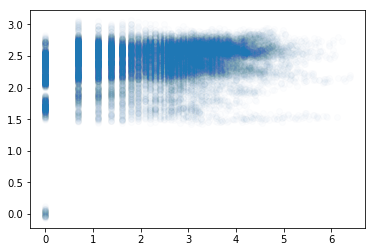

In [167]:
%%time
model = Pipeline([
    ('ohe', OneHotEncoder(categorical_features=[63, 64], sparse=False)),
    ('mms', MinMaxScaler(feature_range=(0, 1), copy=False)),
    ('rg', Ridge(alpha=10))
])

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_in_log, 
    test_size=0.2, 
    random_state=42)

model_gs = GridSearchCV(
    model,
    {'rg__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    cv=5,
    n_jobs=2
)

model_gs.fit(X_train, y_train)
print("Best params: ", model_gs.best_params_)

y_pred = model_gs.predict(X_test)

plt.figu
plt.plot(y_test, y_pred, 'o', alpha=0.01)

Best params:  {'rf__n_estimators': 100}
CPU times: user 1min 10s, sys: 1.3 s, total: 1min 11s
Wall time: 6min 41s


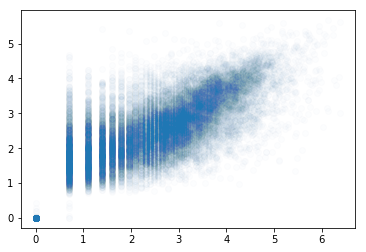

In [168]:
%%time
model = Pipeline([
    ('ohe', OneHotEncoder(categorical_features=[63, 64], sparse=False)),
    ('mms', MinMaxScaler(feature_range=(0, 1), copy=False)),
    ('rf', RandomForestRegressor(n_estimators=10))
])

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_in_log, 
    test_size=0.2, 
    random_state=42)

model_gs = GridSearchCV(
    model,
    {'rf__n_estimators': [10, 50, 100]},
    cv=5,
    n_jobs=2
)

model_gs.fit(X_train, y_train)
print("Best params: ", model_gs.best_params_)

y_pred = model_gs.predict(X_test)
plt.plot(y_test, y_pred, 'o', alpha=0.01)

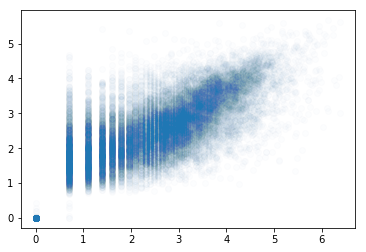

In [169]:
plt.plot(y_test, y_pred, 'o', alpha=0.01)

In [174]:
y_test_raw = np.array(np.exp(y_test)-1)
y_pred_raw = np.exp(y_pred)-1

(0, 100)

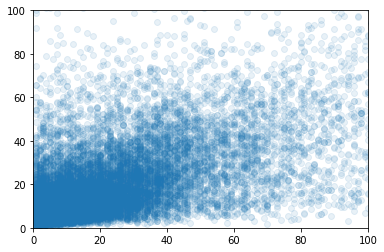

In [178]:
plt.plot(y_test_raw, y_pred_raw, 'o', alpha=0.1)
plt.xlim(0, 100)
plt.ylim(0, 100)